In [1]:
import tensorflow as tf
import tensorflow.keras.datasets as datasets
from tensorflow.keras.layers import Input, Conv2D,BatchNormalization, AveragePooling2D, Flatten, Dense,Activation, Dropout, MaxPooling2D
import tensorflow.keras.layers.experimental.preprocessing
from matplotlib import pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
import numpy
import random
from skimage import transform
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2



Using TensorFlow backend.


(50000, 32, 32, 3)


[]

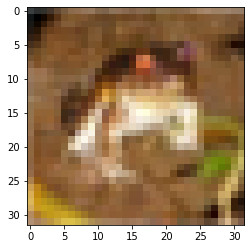

In [2]:
cifar10 = datasets.cifar10
(xtrain,ytrain),(xtest,ytest) = cifar10.load_data()
xtrain = tf.cast(xtrain,tf.float32)/255
xtest = tf.cast(xtest,tf.float32)/255


print(xtrain.shape)
plt.imshow(xtrain[0])
plt.plot()


In [3]:
WEIGHT_DECAY       = 5e-4

def identity_block(filters,input_tensor):
    
    X = Conv2D(filters,(3,3),padding='same',kernel_regularizer=l2(WEIGHT_DECAY))(input_tensor)
    X = BatchNormalization()(X)
    X = tf.nn.relu(X)
    
    
    X = Conv2D(filters,(3,3),padding='same',kernel_regularizer=l2(WEIGHT_DECAY))(X)
    X = BatchNormalization()(X)
    
    X += input_tensor
    
    return tf.nn.relu(X)
    
def conv_block(filters,input_tensor):
    X = Conv2D(filters,(3,3),padding='same',kernel_regularizer=l2(WEIGHT_DECAY))(input_tensor)
    X = BatchNormalization()(X)
    X = tf.nn.relu(X)
    
    X = Conv2D(filters,(3,3),padding='same',kernel_regularizer=l2(WEIGHT_DECAY))(X)
    X = BatchNormalization()(X)
    
    
    X += BatchNormalization()(Conv2D(filters,(3,3),padding='same',kernel_regularizer=l2(WEIGHT_DECAY))(input_tensor))
    
    return tf.nn.relu(X)


In [47]:


def Resnet34(input_tensor):
   
    X = Conv2D(64,(3,3))(input_tensor)
    X = BatchNormalization()(X)
    X = MaxPooling2D((2,2))(X)
    
    X = identity_block(64,X)
    X = identity_block(64,X)
    X = identity_block(64,X)
    
    X = conv_block(128,X)
    X = identity_block(128,X)
    X = identity_block(128,X)
    X = identity_block(128,X)
    
    
    X = conv_block(256,X)
    X = identity_block(256,X)
    X = identity_block(256,X)
    X = identity_block(256,X)
    X = identity_block(256,X)
    X = identity_block(256,X)
    
    X = conv_block(512,X)
    X = identity_block(512,X)
    X = identity_block(512,X)
    
    X = AveragePooling2D((2,2))(X)
    
    X = Flatten()(X)
    X = Dense(1000, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = BatchNormalization()(X)
    X = Dense(1000, activation='relu')(X)
    X = Dropout(0.2)(X)
    X = BatchNormalization()(X)
    X = Dense(10, activation = 'softmax')(X)
    
    
    return X
    

In [48]:
img_input = Input(shape=(32,32,3))
output = Resnet34(img_input)
model = Model(img_input,output)

model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_108 (Conv2D)             (None, 30, 30, 64)   1792        input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_114 (BatchN (None, 30, 30, 64)   256         conv2d_108[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 15, 15, 64)   0           batch_normalization_114[0][0]    
____________________________________________________________________________________________

In [49]:
model.compile(loss="sparse_categorical_crossentropy",optimizer='adam',metrics=['accuracy'])

In [7]:

datagen = ImageDataGenerator(
        
        rotation_range=30,
        width_shift_range=0.125,
        height_shift_range=0.125,
        shear_range=0.125,
        rescale=0/1.,
        zoom_range=0.125,
        horizontal_flip=True,
        fill_mode='nearest')



datagen.fit(xtrain)

In [6]:
train_acc = []

class TestCallback(Callback):
    def __init__(self, test_data):
        train_acc = []
        self.test_data = test_data

    def on_epoch_end(self, epoch, logs={}):
        x, y = self.test_data
        loss, acc = self.model.evaluate(x, y, verbose=1)
        train_acc.append(acc)
        

In [52]:
history = model.fit(datagen.flow(xtrain, ytrain, batch_size=64),epochs=100,callbacks=[TestCallback((xtest, ytest))])

  ...
    to  
  ['...']
Train for 782 steps
Epoch 1/100
782/782 [==============================] - 120s 154ms/step - loss: 2.1189 - accuracy: 0.2524
Epoch 2/100
782/782 [==============================] - 114s 146ms/step - loss: 1.8749 - accuracy: 0.3205
Epoch 3/100
782/782 [==============================] - 114s 146ms/step - loss: 1.7554 - accuracy: 0.3607
Epoch 4/100
782/782 [==============================] - 114s 146ms/step - loss: 1.6737 - accuracy: 0.3907
Epoch 5/100
782/782 [==============================] - 114s 146ms/step - loss: 1.5742 - accuracy: 0.4309
Epoch 6/100
782/782 [==============================] - 114s 146ms/step - loss: 1.5064 - accuracy: 0.4568
Epoch 7/100
782/782 [==============================] - 114s 146ms/step - loss: 1.4134 - accuracy: 0.4934
Epoch 8/100
782/782 [==============================] - 114s 146ms/step - loss: 1.3906 - accuracy: 0.5016
Epoch 9/100
782/782 [==============================] - 114s 146ms/step - loss: 1.3153 - accuracy: 0.5287
Epoch 10/1

In [55]:
eval_hist = model.evaluate(xtest,ytest,batch_size=64)

10000/10000 [==============================] - 7s 700us/sample - loss: 0.3856 - accuracy: 0.8766


dict_keys(['loss', 'accuracy'])


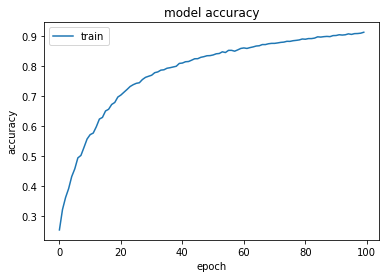

In [54]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [10]:
def Resnet50withfractionpooling(input_tensor):
   
    X = Conv2D(64,(3,3))(input_tensor)
    X = BatchNormalization()(X)
    
    X = MaxPooling2D((2,2))(X)
    
    X = identity_block(64,X)
    X = identity_block(64,X)
    X = identity_block(64,X)
    
    X = tf.nn.fractional_max_pool(X, [1.0, 1.41, 1.41, 1.0], pseudo_random=True, overlapping=True)[0]
    
    X = conv_block(128,X)
    X = identity_block(128,X)
    X = identity_block(128,X)
    X = identity_block(128,X)
    
    
    X = tf.nn.fractional_max_pool(X, [1.0, 1.41, 1.41, 1.0], pseudo_random=True, overlapping=True)[0]
    
    
    X = conv_block(256,X)
    X = identity_block(256,X)
    X = identity_block(256,X)
    X = identity_block(256,X)
    X = identity_block(256,X)
    X = identity_block(256,X)
    
    
    X = tf.nn.fractional_max_pool(X, [1.0, 1.2, 1.2, 1.0], pseudo_random=True, overlapping=True)[0]
    
    X = conv_block(512,X)
    X = identity_block(512,X)
    X = identity_block(512,X)
    
    X = tf.nn.fractional_max_pool(X, [1.0, 1.41, 1.41, 1.0], pseudo_random=True, overlapping=True)[0]
    
    X = Flatten()(X)
    X = BatchNormalization()(X)

    X = Dense(1024, activation='relu')(X)
    X = BatchNormalization()(X)
    
    X = Dense(512, activation='relu')(X)
    
    X = BatchNormalization()(X)
    X = Dense(10, activation = 'softmax')(X)
    
    
    return X
    

In [147]:
img_input = Input(shape=(32,32,3))
output = Resnet34withfractionpooling(img_input)
model2 = Model(img_input,output)

model2.summary()

Model: "model_21"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_758 (Conv2D)             (None, 30, 30, 64)   1792        input_23[0][0]                   
__________________________________________________________________________________________________
batch_normalization_799 (BatchN (None, 30, 30, 64)   256         conv2d_758[0][0]                 
__________________________________________________________________________________________________
max_pooling2d_31 (MaxPooling2D) (None, 15, 15, 64)   0           batch_normalization_799[0][0]    
___________________________________________________________________________________________

dict_keys(['loss', 'accuracy'])


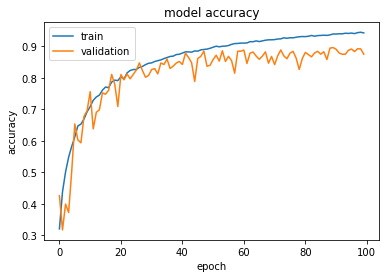

In [105]:
first100trainacc = train_acc 
print(history.history.keys())
#  "Accuracy"

plt.plot(history2.history['accuracy'])
plt.plot(first100trainacc)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [109]:
train_acc = []
history3 = model2.fit(datagen.flow(xtrain, ytrain, batch_size=64),epochs=100,callbacks=[TestCallback((xtest, ytest))])

  ...
    to  
  ['...']
Train for 782 steps
Epoch 1/100
782/782 [==============================] - 78s 100ms/step - loss: 0.2036 - accuracy: 0.9300
Epoch 2/100
782/782 [==============================] - 79s 101ms/step - loss: 0.1930 - accuracy: 0.9320
Epoch 3/100
782/782 [==============================] - 78s 100ms/step - loss: 0.1930 - accuracy: 0.9327
Epoch 4/100
782/782 [==============================] - 78s 100ms/step - loss: 0.1913 - accuracy: 0.9331
Epoch 5/100
782/782 [==============================] - 78s 100ms/step - loss: 0.1856 - accuracy: 0.9369
Epoch 6/100
782/782 [==============================] - 79s 100ms/step - loss: 0.1897 - accuracy: 0.9335
Epoch 7/100
782/782 [==============================] - 79s 101ms/step - loss: 0.1845 - accuracy: 0.9354
Epoch 8/100
782/782 [==============================] - 78s 100ms/step - loss: 0.1726 - accuracy: 0.9402
Epoch 9/100
782/782 [==============================] - 78s 100ms/step - loss: 0.1770 - accuracy: 0.9384
Epoch 10/100
782/78

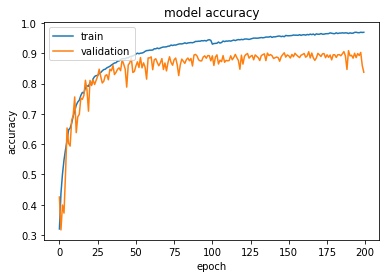

In [111]:
first200trainacc = first100trainacc + train_acc 
history = history2.history['accuracy'] + history3.history['accuracy']
plt.plot(history)
plt.plot(first200trainacc)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [11]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import LearningRateScheduler

def scheduler(epoch):
    if epoch < 150:
        return 0.1
    if epoch < 225:
        return 0.01
    return 0.001


change_lr = LearningRateScheduler(scheduler)
test = TestCallback((xtest, ytest))
callbacks = [change_lr,test]
 
    
img_input = Input(shape=(32,32,3))
output = Resnet50withfractionpooling(img_input)
resnet50 = Model(img_input,output)

resnet50.summary()

sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
resnet50.compile(loss='sparse_categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])



Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_36 (Conv2D)              (None, 30, 30, 64)   1792        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_39 (BatchNo (None, 30, 30, 64)   256         conv2d_36[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 15, 15, 64)   0           batch_normalization_39[0][0]     
____________________________________________________________________________________________

In [12]:
train_acc = []
history3 = resnet50.fit(datagen.flow(xtrain, ytrain, batch_size=128),epochs=300,callbacks=callbacks)

  ...
    to  
  ['...']
Train for 391 steps
Epoch 1/300
391/391 [==============================] - 82s 209ms/step - loss: 18.2256 - accuracy: 0.2627
Epoch 2/300
391/391 [==============================] - 75s 192ms/step - loss: 9.3364 - accuracy: 0.3820
Epoch 3/300
391/391 [==============================] - 75s 193ms/step - loss: 5.1086 - accuracy: 0.4414
Epoch 4/300
391/391 [==============================] - 74s 191ms/step - loss: 3.2096 - accuracy: 0.4875
Epoch 5/300
391/391 [==============================] - 74s 190ms/step - loss: 2.1787 - accuracy: 0.5383
Epoch 6/300
391/391 [==============================] - 74s 190ms/step - loss: 1.7007 - accuracy: 0.5746
Epoch 7/300
391/391 [==============================] - 74s 189ms/step - loss: 1.4749 - accuracy: 0.6010
Epoch 8/300
391/391 [==============================] - 74s 190ms/step - loss: 1.3600 - accuracy: 0.6263
Epoch 9/300
391/391 [==============================] - 74s 190ms/step - loss: 1.2971 - accuracy: 0.6485
Epoch 10/300
391/3

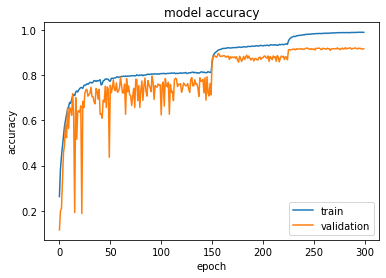

In [13]:

plt.plot(history3.history['accuracy'])
plt.plot(train_acc)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

In [15]:
resnet50.save_weights('./resnet50-300')


In [21]:
resnet50.save('my_model.h5') 

In [22]:
new_model = tf.keras.models.load_model('my_model.h5')
